# 1D Helmholtz Multilevel Development: Repetitive + Alignment
* Constant $k$.
* Discretization: 5-point (4th order).
* Kaczmarz relaxation.
* Fixed-domain problem; repetitive, so we sample windows from a test vector.

In [108]:
import collections
import logging
import numpy as np
import matplotlib.pyplot as plt
import helmholtz as hm
import helmholtz.analysis
import helmholtz.repetitive.coarsening_repetitive as hrc
import pandas as pd
import scipy.sparse
import sklearn.metrics.pairwise
import sys
from numpy.ma.testutils import assert_array_almost_equal
from scipy.linalg import eig, norm, svd
from scipy.sparse.linalg import eigs
from scipy import optimize

%load_ext autoreload
%autoreload 2

np.set_printoptions(linewidth=500, precision=3, suppress=True, threshold=100000)
for handler in logging.root.handlers[:]: logging.root.removeHandler(handler)
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(levelname)-8s %(message)s",
                    datefmt="%a, %d %b %Y %H:%M:%S")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.float_format = "{:,.2f}".format

logger = logging.getLogger("main")
_LOGGER = logger

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [109]:
# Fixed seed for reproducible results.
np.random.seed(1)

# Domain size.
n = 96
# Scaled wave number. Fit so lam_min = 0 (integer # periods in domain).
kh = helmholtz.analysis.ideal.find_singular_kh("5-point", n)[0]
#kh = 0.5

repetitive = True

# Number of test vectors.
num_examples = 3
threshold = 0.1

# Boottstrapping parameters.
interpolation_method = "ls"
neighborhood = "extended" #"aggregate" # "extended"
num_test_examples = 5
leeway_factor = 1.3

## Level 0->1 Coarsening

In [110]:
# Create fine-level matrix.
a = hm.linalg.helmholtz_1d_discrete_operator(kh, "5-point", n) #, bc="bloch")
# Use default Kacmzarz for kh != 0.
level = hm.setup.hierarchy.create_finest_level(a, relaxer=hm.solve.relax.GsRelaxer(a) if kh == 0 else None)

# Initialize hierarchy to 1-level.
finest = 0
multilevel = hm.setup.hierarchy.multilevel.Multilevel.create(level)

### Relaxation

INFO     kh 0.5233853805513016
INFO     Relax at level 0 size 96
INFO     Iter     |r|                         |x|         RER
INFO     0     1.316e+00                    4.468e-01    2.940
INFO     1     7.242e-01 (0.551) [0.551]    3.424e-01    2.116 (0.719)
INFO     2     4.219e-01 (0.584) [0.567]    2.936e-01    1.441 (0.681)
INFO     3     2.655e-01 (0.630) [0.588]    2.686e-01    0.993 (0.689)
INFO     4     1.829e-01 (0.689) [0.612]    2.537e-01    0.724 (0.730)
INFO     5     1.382e-01 (0.756) [0.638]    2.437e-01    0.569 (0.787)
INFO     6     1.125e-01 (0.814) [0.665]    2.361e-01    0.478 (0.840)
INFO     7     9.668e-02 (0.858) [0.690]    2.300e-01    0.420 (0.881)
INFO     8     8.588e-02 (0.887) [0.712]    2.249e-01    0.381 (0.907)
INFO     9     7.792e-02 (0.907) [0.731]    2.205e-01    0.353 (0.925)
INFO     10    7.170e-02 (0.920) [0.748]    2.166e-01    0.330 (0.936)
INFO     11    6.671e-02 (0.930) [0.763]    2.131e-01    0.312 (0.946)
INFO     12    6.263e-02 (0.9

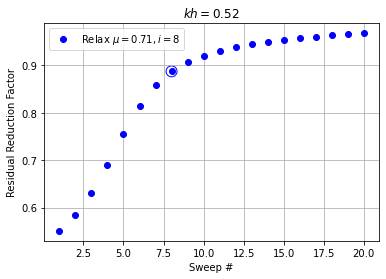

In [111]:
_LOGGER.info("kh {}".format(kh))
x_log = []
r_log = []
work = 1

_LOGGER.info("Relax at level {} size {}".format(finest, level.size))
b = np.zeros((a.shape[0], num_examples))

factor, num_sweeps, residual, conv, rer, conv_factor = hm.solve.smoothing.shrinkage_factor(
    level.operator, lambda x, b: level.relax(x, b), (a.shape[0], ), 
    print_frequency=1, max_sweeps=20, slow_conv_factor=1.1, leeway_factor=leeway_factor)
_LOGGER.info("Relax conv {:.2f} shrinkage {:.2f} PODR RER {:.2f} after {} sweeps. Work {:.1f} eff {:.2f}".format(
    conv_factor, factor, np.mean(rer[num_sweeps]), num_sweeps, work, np.mean(residual[num_sweeps] / residual[0]) ** (1/(num_sweeps * work))))

title = "Relax"
color = "blue"
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
hm.solve.smoothing.plot_diminishing_returns_point(factor, num_sweeps, conv, ax, title=title, color=color)
print("{:<5s} conv {:.2f} shrinkage {:.2f} PODR RER {:.2f} after {:>2d} sweeps. Work {:>2d} efficiency {:.2f}".format(
    title, conv_factor, factor, np.mean(rer[num_sweeps]), num_sweeps, work, np.mean(residual[num_sweeps] / residual[0]) ** (1/(num_sweeps * work))))
ax.set_title(r"$kh = {:.2f}$".format(kh))
ax.legend();

In [112]:
# Generate relaxed vectors.
# TODO(orenlivne): generalize to d-dimensions. This is specific to 1D.
level = multilevel[0]
x = hm.solve.run.random_test_matrix((level.size,), num_examples=num_examples)
# Improve vectors with 1-level relaxation.
_LOGGER.info("Random Start")
_LOGGER.info("RER {:.3f}".format(norm(level.a.dot(x)) / norm(x)))
x_log.append(x)

_LOGGER.info("Generating {} TVs with {} sweeps".format(x.shape[1], num_sweeps))
x, _ = hm.solve.run.run_iterative_method(
    level.operator, lambda x: level.relax(x, b), x, num_sweeps=num_sweeps)
_LOGGER.info("RER {:.3f}".format(norm(level.a.dot(x)) / norm(x)))
x_log.append(x)

INFO     Random Start
INFO     RER 3.021
INFO     Generating 3 TVs with 8 sweeps
INFO     RER 0.347


### Coarsening

In [113]:
# Coarsening. Force 2 coarse vars per aggregate so we can test alignment.
aggregate_size = 4
num_components = 2

In [114]:
# coarsener = hm.setup.coarsening_uniform.UniformCoarsener(
#     level, x, num_sweeps, repetitive=repetitive)
# info = coarsener.get_coarsening_info(1, fmt="dataframe")
# r, aggregate_size, nc, cr, mean_energy_error, mock_conv, mock_work, mock_efficiency = \
#     coarsener.get_optimal_coarsening(1)
# _LOGGER.info("R {} a {} nc {} cr {:.2f} mean_energy_error {:.4f}; mock cycle num_sweeps {} conv {:.2f} "
#              "eff {:.2f}".format(
#     r.shape, aggregate_size, nc, cr, mean_energy_error, num_sweeps, mock_conv, mock_efficiency))
# coarsener.get_coarsening_info(1, fmt="dataframe")

In [115]:
def create_coarsening(x, aggregate_size, num_components):
    # Construct coarsening on an aggregate.
    x_aggregate_t = np.concatenate(
        tuple(hm.linalg.get_window(x, offset, aggregate_size)
              for offset in range(max((4 * aggregate_size) // x.shape[1], 1))), axis=1).transpose()

    # Tile the same coarsening over all aggregates.
    r, s = hm.setup.coarsening_uniform.create_coarsening(x_aggregate_t, num_components)
    return hrc.Coarsener(r)

def plot_coarsening(R, x):
    xc = R.dot(x)
    display(pd.DataFrame(R[:5,:10].todense()))

    fig, axs = plt.subplots(1, 3, figsize=(14, 4))

    ax = axs[0]
    for i in range(2):
        ax.plot(x[:, i])
    ax.set_title("$x$")
    ax.grid(True);

    ax = axs[1]
    for i in range(2):
        ax.plot(xc[::2, i])
    ax.set_title("$x^c$ Species 0")
    ax.grid(True);


    ax = axs[2]
    for i in range(2):
        ax.plot(xc[1::2, i])
    ax.set_title("$x^c$ Species 1")
    ax.grid(True);

def mock_conv_factor_for_domain_size(kh, r, aggregate_size, domain_size, nu_values):
    """Returns thre mock cycle conv factor for a domain of size m instead of n."""
    # Create fine-level matrix.
    a = hm.linalg.helmholtz_1d_operator(kh, domain_size)
    # Use default Kacmzarz for kh != 0.
    local_level = hm.setup.hierarchy.create_finest_level(a, relaxer=hm.solve.relax.GsRelaxer(a) if kh == 0 else None)
    r_csr = r.tile(domain_size // aggregate_size)
    return np.array([hm.setup.auto_setup.mock_cycle_conv_factor(local_level, r_csr, nu) for nu in nu_values])

,0,1,2,3,4,5,6,7,8,9
0,0.45,0.63,0.55,0.30,0.00,0.00,0.00,0.00,0.00,0.00
1,0.64,0.15,-0.33,-0.67,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.45,0.63,0.55,0.30,0.00,0.00
3,0.00,0.00,0.00,0.00,0.64,0.15,-0.33,-0.67,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.45,0.63


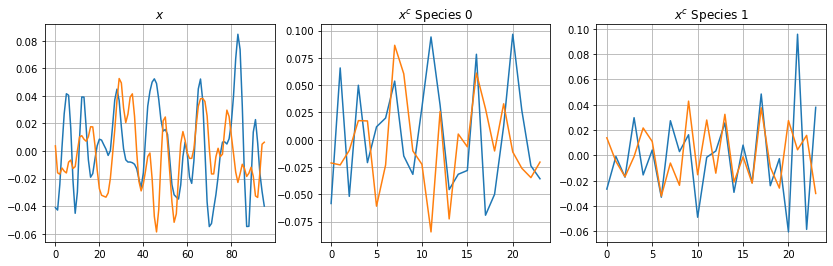

In [116]:
r = create_coarsening(x, aggregate_size, num_components)
R = r.tile(level.size // aggregate_size)
xc = R.dot(x)
plot_coarsening(R, x)

### Local Mock Cycle (LMC) Rate
On a domain of size $4 a$, $a$ = aggregate size.

In [117]:
# Calculate local mock cycle convergence rate on a domain of size 4 * aggregate_size.
m = 4
nu_values = np.arange(1, num_sweeps + 1)
mock_conv = mock_conv_factor_for_domain_size(kh, r, aggregate_size, m * aggregate_size, nu_values)
_LOGGER.info("Mock cycle conv factor {}".format(
    np.array2string(mock_conv, precision=3)))

INFO     Mock cycle conv factor [0.472 0.239 0.124 0.133 0.1   0.069 0.06  0.041]


### Interpolation
Using $P = R^T$ to start.

In [118]:
# caliber = 2
# interpolation_method = "svd"
# neighborhood = "extended"

# p = create_interpolation(
#     x_level, level.a, r, interpolation_method, aggregate_size=aggregate_size, nc=num_components, 
#     neighborhood=neighborhood, repetitive=repetitive, target_error=target_error,
#     caliber=caliber)

# for title, x_set in ((("all", x),) if repetitive else (("fit", x_fit), ("test", x_test))):
#     error = norm(x_set - p.dot(r.dot(x_set)), axis=0) / norm(x_set, axis=0)
#     error_a = norm(level.a.dot(x_set - p.dot(r.dot(x_set))), axis=0) / norm(x_set, axis=0)
#     _LOGGER.info(
#         "{:<4s} set size {:<2d} P L2 error mean {:.2f} max {:.2f} A error mean {:.2f} max {:.2f}".format(
#             title, len(error), np.mean(error), np.max(error), np.mean(error_a), np.max(error_a)))

In [119]:
def create_two_level_hiearchy(kh, m, r, p):
    a = hm.linalg.helmholtz_1d_operator(kh, m)
    r_csr = r.tile(m // aggregate_size)
    p_csr = hm.linalg.tile_array(p, m // aggregate_size)
    level0 = hm.setup.hierarchy.create_finest_level(a) #, relaxer=hm.solve.relax.GsRelaxer(a) if kh == 0 else None)
    level1 = hm.setup.hierarchy.create_coarse_level(level0.a, level0.b, r_csr, p_csr)
    multilevel = hm.hierarchy.multilevel.Multilevel.create(level0)
    multilevel.add(level1)
    return multilevel

def two_level_conv_factor(multilevel, nu, print_frequency: int = None):
    level = multilevel.finest_level
    n = level.size
    # Test two-level cycle convergence for A*x=b with random b.
    b = np.random.random((n, ))
    two_level_cycle = lambda y: hm.solve.solve_cycle.solve_cycle(multilevel, 1.0, nu, 0, nu_coarsest=-1, debug=False, rhs=b).run(y)
    residual = lambda x: b - multilevel[0].operator(x)
    return hm.solve.run.run_iterative_method(
        residual, two_level_cycle, np.random.random((n, )), 15, print_frequency=print_frequency)

In [120]:
# P = R^T on a single aggregate.
p = r.tile(1).transpose()
print(p.todense())

[[ 0.453  0.644]
 [ 0.63   0.151]
 [ 0.555 -0.334]
 [ 0.301 -0.671]]


### Local Two-level Cycle (L2C) Rate

In [121]:
nu = 2
local_multilevel = create_two_level_hiearchy(kh, m * aggregate_size, r, p)
y, _ = two_level_conv_factor(local_multilevel, nu, print_frequency=1)

INFO         0 |r| 2.725e+00 RER 1.09799
INFO         1 |r| 3.281e+00 (1.20394) RER 0.31172 (0.28390) 10.526
INFO         2 |r| 1.363e+00 (0.41544) RER 0.18517 (0.59403) 7.361
INFO         3 |r| 3.131e-01 (0.22969) RER 0.04079 (0.22027) 7.676
INFO         4 |r| 1.234e-01 (0.39427) RER 0.01570 (0.38492) 7.863
INFO         5 |r| 2.635e-02 (0.21349) RER 0.00338 (0.21517) 7.801
INFO         6 |r| 9.591e-03 (0.36394) RER 0.00123 (0.36439) 7.792
INFO         7 |r| 3.186e-03 (0.33220) RER 0.00041 (0.33196) 7.797
INFO         8 |r| 7.279e-04 (0.22845) RER 0.00009 (0.22845) 7.798
INFO         9 |r| 2.893e-04 (0.39747) RER 0.00004 (0.39750) 7.797
INFO        10 |r| 8.242e-05 (0.28486) RER 0.00001 (0.28486) 7.797
INFO        11 |r| 3.234e-05 (0.39238) RER 0.00000 (0.39238) 7.797
INFO        12 |r| 8.846e-06 (0.27354) RER 0.00000 (0.27354) 7.797
INFO        13 |r| 4.081e-06 (0.46134) RER 0.00000 (0.46134) 7.797
INFO        14 |r| 1.560e-06 (0.38232) RER 0.00000 (0.38232) 7.797
INFO        15 |r| 5

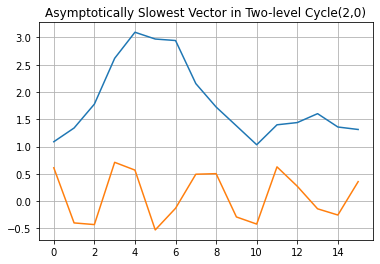

In [122]:
# Asymptotic vector.
plt.title("Asymptotically Slowest Vector in Two-level Cycle({},0)".format(nu))
e = y - local_multilevel[1].p.dot(local_multilevel[1].r.dot(y))
plt.plot(y);
plt.plot(e);
plt.grid(True);

In [88]:
two_level_conv = np.array([
    two_level_conv_factor(create_two_level_hiearchy(kh, m * aggregate_size, r, p), nu)[1]
     for nu in nu_values])

conv = pd.DataFrame(np.array((mock_conv, two_level_conv)).transpose(), 
                    index=nu_values, columns=("Mock", "Two-level"))
display(conv)

,Mock,Two-level
1,0.47,0.49
2,0.24,0.37
3,0.12,0.39
4,0.13,0.62
5,0.10,0.60
6,0.07,0.51
7,0.06,0.44
8,0.04,0.39


In [139]:
# Compare the L2 projection norm and the A*A'-orthogonal projection norms, which gives an indication
# that the mock cycle rates are guaranteed to be good predictors of the two-level rates [Rob & James].
R = r.tile(n // aggregate_size)
_LOGGER.info("L2 projection norm {:.2f} A*A' projection norm {:.2f}".
             format(norm(R.todense(), ord=2), norm((R.dot(multilevel[0].a)).todense(), ord=2)))

INFO     L2 projection norm 1.00 A*A' projection norm 2.82


This intepolation is good up to $\nu = 2$, conv $\approx 0.5$.

<!-- ### Build Coarse Level: Two-level Bootstrap Cycle -->

In [89]:
# max_levels = 2
# num_bootstrap_steps = 1

# # Bootstrap with an increasingly deeper hierarchy (add one level at a time).
# num_levels = 2
# _LOGGER.info("bootstrap on grid size {} with {} levels".format(x.shape[0], max_levels))
# _LOGGER.info("-" * 80)
# for i in range(num_bootstrap_steps):
#     _LOGGER.info("Bootstrap step {}/{}".format(i + 1, num_bootstrap_steps))
#     # Set relax_conv_factor to a high value so that we never append a bootstrap vector to the TV set.
#     x, multilevel = hm.setup.auto_setup.bootstap(
#         x, multilevel, num_levels, 2.0,
#         num_sweeps=num_sweeps, interpolation_method=interpolation_method, 
#         neighborhood=neighborhood, repetitive=repetitive, target_error=0.1)
#     x_log.append(x)
#     r_log.append(multilevel[1].r)
#     _LOGGER.info("RER {:.6f}".format(norm(a.dot(x)) / norm(x)))
#     _LOGGER.info("-" * 80)

### Two-level Hierarchy

In [90]:
multilevel = hm.hierarchy.multilevel.Multilevel.create(level)
l = 1
r_csr = r.tile(n // aggregate_size)
p_csr = r_csr.transpose()
level1 = hm.setup.hierarchy.create_coarse_level(level.a, level.b, r_csr, p_csr)
_LOGGER.info("Level {} size {}".format(l, level1.size))
multilevel.add(level1)

INFO     Level 1 size 48


#### Level 0

In [91]:
pd.DataFrame(multilevel[0].a.tocsr()[:10,:10].todense())

,0,1,2,3,4,5,6,7,8,9
0,-2.23,1.33,-0.08,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,1.33,-2.23,1.33,-0.08,0.00,0.00,0.00,0.00,0.00,0.00
2,-0.08,1.33,-2.23,1.33,-0.08,0.00,0.00,0.00,0.00,0.00
3,0.00,-0.08,1.33,-2.23,1.33,-0.08,0.00,0.00,0.00,0.00
4,0.00,0.00,-0.08,1.33,-2.23,1.33,-0.08,0.00,0.00,0.00
5,0.00,0.00,0.00,-0.08,1.33,-2.23,1.33,-0.08,0.00,0.00
6,0.00,0.00,0.00,0.00,-0.08,1.33,-2.23,1.33,-0.08,0.00
7,0.00,0.00,0.00,0.00,0.00,-0.08,1.33,-2.23,1.33,-0.08
8,0.00,0.00,0.00,0.00,0.00,0.00,-0.08,1.33,-2.23,1.33
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.08,1.33,-2.23


#### Level 1

In [92]:
pd.DataFrame(multilevel[1].a[:10,:10].todense())

,0,1,2,3,4,5,6,7,8,9
0,-0.16,-0.15,0.15,0.22,0.00,0.00,0.00,0.00,0.00,0.00
1,-0.15,-1.45,-0.36,-0.55,0.00,0.00,0.00,0.00,0.00,0.00
2,0.15,-0.36,-0.16,-0.15,0.15,0.22,0.00,0.00,0.00,0.00
3,0.22,-0.55,-0.15,-1.45,-0.36,-0.55,0.00,0.00,0.00,0.00
4,0.00,0.00,0.15,-0.36,-0.16,-0.15,0.15,0.22,0.00,0.00
5,0.00,0.00,0.22,-0.55,-0.15,-1.45,-0.36,-0.55,0.00,0.00
6,0.00,0.00,0.00,0.00,0.15,-0.36,-0.16,-0.15,0.15,0.22
7,0.00,0.00,0.00,0.00,0.22,-0.55,-0.15,-1.45,-0.36,-0.55
8,0.00,0.00,0.00,0.00,0.00,0.00,0.15,-0.36,-0.16,-0.15
9,0.00,0.00,0.00,0.00,0.00,0.00,0.22,-0.55,-0.15,-1.45


In [93]:
pd.DataFrame(multilevel[1].p[:10, :10].todense())

,0,1,2,3,4,5,6,7,8,9
0,0.45,0.64,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.63,0.15,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.55,-0.33,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.30,-0.67,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.45,0.64,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.63,0.15,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.55,-0.33,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.30,-0.67,0.00,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.45,0.64,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.63,0.15,0.00,0.00,0.00,0.00


In [94]:
pd.DataFrame(multilevel[1].r[:10,:10].todense())

,0,1,2,3,4,5,6,7,8,9
0,0.45,0.63,0.55,0.30,0.00,0.00,0.00,0.00,0.00,0.00
1,0.64,0.15,-0.33,-0.67,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.45,0.63,0.55,0.30,0.00,0.00
3,0.00,0.00,0.00,0.00,0.64,0.15,-0.33,-0.67,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.45,0.63
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.64,0.15
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


### Coarse-level Relaxation Shrinkage

INFO     Relax at level 1 size 48
INFO     Iter     |r|                         |x|         RER
INFO     0     5.327e-01                    4.469e-01    1.194
INFO     1     1.680e-01 (0.319) [0.319]    3.293e-01    0.515 (0.433)
INFO     2     9.638e-02 (0.575) [0.428]    3.013e-01    0.325 (0.630)
INFO     3     8.512e-02 (0.883) [0.545]    2.862e-01    0.301 (0.931)
INFO     4     7.611e-02 (0.895) [0.617]    2.738e-01    0.283 (0.937)
INFO     5     6.895e-02 (0.906) [0.666]    2.629e-01    0.267 (0.945)
INFO     6     6.291e-02 (0.913) [0.702]    2.532e-01    0.254 (0.949)
INFO     7     5.768e-02 (0.917) [0.729]    2.446e-01    0.241 (0.950)
INFO     8     5.313e-02 (0.921) [0.751]    2.371e-01    0.230 (0.952)
INFO     9     4.915e-02 (0.925) [0.768]    2.303e-01    0.219 (0.954)
INFO     10    4.566e-02 (0.929) [0.783]    2.243e-01    0.210 (0.955)
INFO     11    4.259e-02 (0.933) [0.796]    2.189e-01    0.201 (0.957)
INFO     12    3.988e-02 (0.936) [0.807]    2.141e-01    0.1

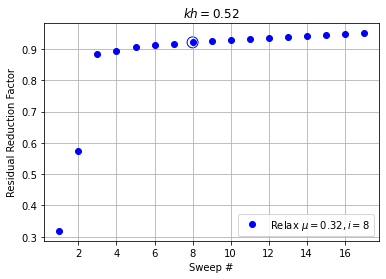

In [95]:
work = 1
l = 1
level = multilevel[l]
_LOGGER.info("Relax at level {} size {}".format(l, level.size))
b = np.zeros((level.size, num_examples))

factor, num_coarse_sweeps, residual, conv, rer, relax_conv_factor = \
    hm.solve.smoothing.shrinkage_factor(
        level.operator, lambda x, b: level.relax(x, b), (level.size, ), 
        print_frequency=1, max_sweeps=20, slow_conv_factor=0.95, leeway_factor=leeway_factor)
_LOGGER.info("Relax conv {:.2f} shrinkage {:.2f} PODR RER {:.2f} after {} sweeps. Work {:.1f} eff {:.2f}".format(
    relax_conv_factor, factor, np.mean(rer[num_coarse_sweeps]), num_coarse_sweeps, work, np.mean(residual[num_coarse_sweeps] / residual[0]) ** (1/(num_coarse_sweeps * work))))

title = "Relax"
color = "blue"
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
hm.solve.smoothing.plot_diminishing_returns_point(factor, num_sweeps, conv, ax, title=title, color=color)
print("{:<5s} conv {:.2f} shrinkage {:.2f} PODR RER {:.2f} after {:>2d} sweeps. Work {:>2d} efficiency {:.2f}".format(
    title, conv_factor, factor, np.mean(rer[num_coarse_sweeps]), num_coarse_sweeps, work, np.mean(residual[num_coarse_sweeps] / residual[0]) ** (1/(num_coarse_sweeps * work))))
ax.set_title(r"$kh = {:.2f}$".format(kh))
ax.legend();

### Relaxation Cycle Shrinkage
We compare relaxation cycle with $\nu_1=2, \nu_2=2, \nu_{coarse}=20$ with the resulting $P$ and $R$ from the bootstrap step, with Kaczmarz relaxation.

INFO     Iter     |r|                         |x|         RER
INFO     0     1.349e+00                    4.471e-01    3.016
INFO     1     7.272e-01 (0.539) [0.539]    3.406e-01    2.139 (0.708)
INFO     2     4.169e-01 (0.574) [0.556]    2.939e-01    1.425 (0.666)
INFO     3     2.574e-01 (0.618) [0.576]    2.713e-01    0.954 (0.670)
INFO     4     1.727e-01 (0.671) [0.599]    2.584e-01    0.672 (0.705)
INFO     5     1.280e-01 (0.742) [0.625]    2.500e-01    0.515 (0.767)
INFO     6     1.022e-01 (0.798) [0.651]    2.438e-01    0.421 (0.819)
INFO     7     8.728e-02 (0.854) [0.677]    2.388e-01    0.367 (0.872)
INFO     8     7.730e-02 (0.885) [0.700]    2.346e-01    0.331 (0.901)
INFO     9     7.027e-02 (0.909) [0.721]    2.309e-01    0.306 (0.923)
INFO     Relax conv 0.91 shrinkage 0.70 PODR RER 0.33 after 8 sweeps. Work 1.0 eff 0.70
INFO     Iter     |r|                         |x|         RER
INFO     0     1.270e+00                    4.463e-01    2.849
INFO     1     1.287e-0

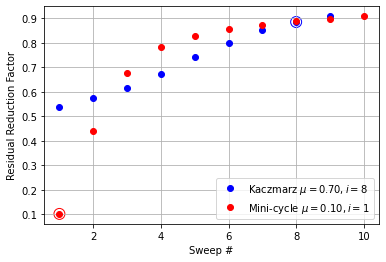

In [96]:
slow_conv_factor = 0.9
nu_pre, nu_post, nu_coarsest = num_sweeps, 0, max(3, num_coarse_sweeps)
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    multilevel, nu_pre=nu_pre, nu_post=nu_post, nu_coarsest=nu_coarsest, leeway_factor=leeway_factor, slow_conv_factor=slow_conv_factor)
num_mini_cycles = method_info["Mini-cycle"][2].shape[0]
_LOGGER.info("Two-level ({}, {}; {}) relaxation cycle is slow after {} steps".format(
    nu_pre, nu_post, nu_coarsest, num_mini_cycles))

### Improve Test Vectors by Relaxation Cycles

In [97]:
def relax_cycle(x):
    return hm.solve.relax_cycle.relax_cycle(multilevel, 1.0, nu_pre, nu_post, nu_coarsest).run(x)

level = multilevel[0]
_LOGGER.info("RER {:.3f}".format(norm(level.a.dot(x)) / norm(x)))
_LOGGER.info("Improving vectors by {} relaxation cycles".format(num_mini_cycles))
x, _ = hm.solve.run.run_iterative_method(level.operator, relax_cycle, x, num_mini_cycles)
_LOGGER.info("RER {:.3f}".format(norm(level.a.dot(x)) / norm(x)))
x_log.append(x)

INFO     RER 0.347
INFO     Improving vectors by 11 relaxation cycles
INFO     RER 0.162


Step  0 s [1.    0.86  0.745 0.543] Energy error [0.784 0.573 0.338 0.   ]
Step  1 s [1.    0.672 0.131 0.049] Energy error [0.566 0.115 0.041 0.   ]
Step  2 s [1.    0.534 0.038 0.028] Energy error [0.473 0.041 0.024 0.   ]


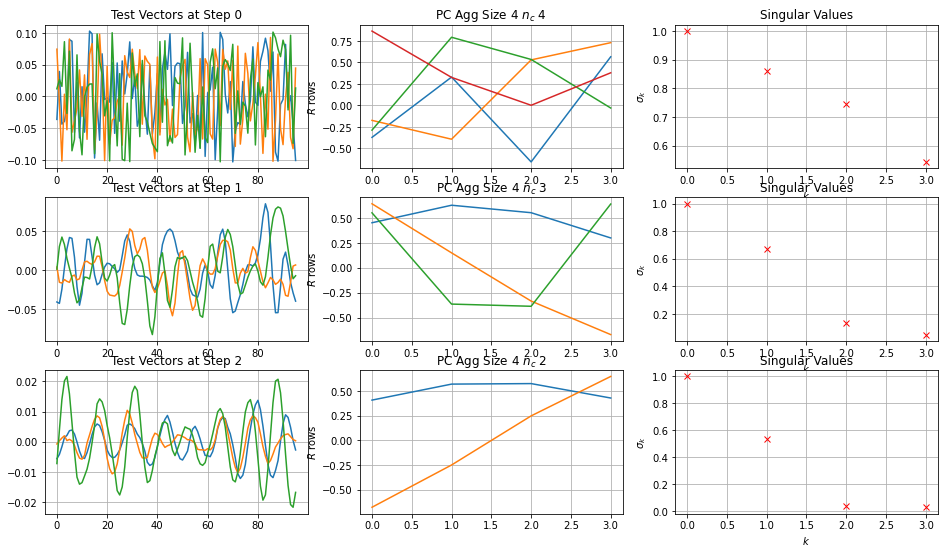

In [98]:
aggregate_size = 4
threshold = 0.1
fig, axs = plt.subplots(len(x_log), 3, figsize=(16, 3 * len(x_log)))
for row, x in enumerate(x_log):
    x_aggregate_t = np.concatenate(
        tuple(hm.linalg.get_window(x, offset, aggregate_size)
              for offset in range(max((4 * aggregate_size) // x.shape[1], 1))), axis=1).transpose()    
#     start, end = 0, aggregate_size
#     x_aggregate_t = x[start:end].transpose()
    r, s = hrc.create_coarsening(x_aggregate_t, threshold)
    r = r.asarray()

    # Relaxed vectors.
    ax = axs[row, 0]
    for i in range(3):
        ax.plot(x[:, i]);
    ax.grid(True)
    ax.set_title(r"Test Vectors at Step {}".format(row))

    ax = axs[row, 1]
    # R should be real-valued, but cast just in case.
    for i, ri in enumerate(np.real(r)):
        ax.plot(ri)
    ax.set_title(r"PC Agg Size {} $n_c$ {}".format(r.shape[1], r.shape[0]))
    ax.set_ylabel(r"$R$ rows")
    ax.grid(True);

    # Singular values, normalized to sigma_max = 1.
    ax = axs[row, 2]
    ax.plot(s / s[0], "rx")
    ax.set_title("Singular Values")
    ax.set_xlabel(r"$k$")
    ax.set_ylabel(r"$\sigma_k$")
    ax.grid(True);
    
    print("Step {:2d}".format(row), "s", s / s[0], "Energy error", (1 - np.cumsum(s ** 2) / sum(s ** 2)) ** 0.5)

## Alignment

INFO     Agg t/pi      f0           fmin         factor   Dist Before   Dist After   
INFO     0   +1.369860 1.76e-03 7.36e-05 ( 23.95) [0.015 0.039] [0.007 0.005] +1.452565 2.28e-05 ( 77.47) [0.015 0.039] [0.007 0.005]
INFO     2   +1.369860 2.75e-03 2.32e-04 ( 11.82) [0.05  0.015] [0.01  0.012] +1.231921 9.19e-05 ( 29.92) [0.05  0.015] [0.01  0.012]
INFO     4   +1.369860 1.03e-03 4.20e-04 (  2.45) [0.026 0.019] [0.015 0.014] +1.518006 3.43e-04 (  3.00) [0.026 0.019] [0.015 0.014]
INFO     6   +1.369860 1.37e-03 2.68e-04 (  5.10) [0.033 0.017] [0.016 0.004] +1.416579 2.58e-04 (  5.29) [0.033 0.017] [0.016 0.004]
INFO     8   +1.369860 2.00e-03 2.90e-04 (  6.91) [0.043 0.013] [0.011 0.013] +1.323946 2.78e-04 (  7.20) [0.043 0.013] [0.011 0.013]
INFO     10  +1.369860 1.55e-03 4.83e-04 (  3.22) [0.032 0.023] [0.02  0.009] +1.499996 3.86e-04 (  4.02) [0.032 0.023] [0.02  0.009]
INFO     12  +1.369860 3.44e-03 2.15e-04 ( 16.01) [0.055 0.02 ] [0.01  0.011] +1.253678 8.48e-05 ( 40.61) [0.0

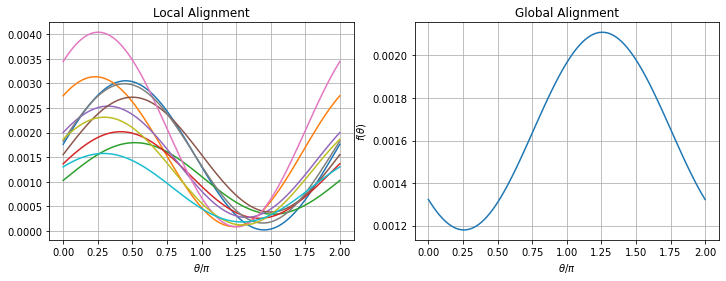

In [99]:
level = multilevel[0]
coarse_level = multilevel[1]
xc = coarse_level.coarsen(x)

hm.setup.alignment.calculate_local_repetitive_rotation_angle(4 * aggregate_size, num_components, xc);

# Local alignment.
_LOGGER.info("Local alignment")
phi = hm.setup.alignment.calculate_local_rotation_angles(level.size, aggregate_size, num_components, xc)

# Global alignment.
_LOGGER.info("Global alignment")
f, tmin = hm.setup.alignment.optimal_rotation_angle(xc)

# Plot f(theta).
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
hm.setup.alignment.plot_min_functions(n, aggregate_size, num_components, xc, ax)
ax.set_title("Local Alignment");

ax = axs[1]
t = np.linspace(0, 2 * np.pi, 100)
ax.plot(t / np.pi, np.array([f(theta) for theta in t]))
ax.grid(True);
ax.set_xlabel(r"$\theta / \pi$")
ax.set_ylabel(r"$f(\theta)$");
ax.set_title("Global Alignment");

In [100]:
# pd.DataFrame(multilevel[1].a.sum(axis=1))

<!-- ### Solving $A x = b$ (Periodic Fixed-Size Domain Problem)
That is, solving on a periodic fixed d
omain. $b$ is a random periodic vector. We start from random $x$. Solving exactly on the coarsest level works fine despite the indefiniteness since the matrix is not (even nearly) singular. -->

In [101]:
# level = multilevel.finest_level
# # Test two-level cycle convergence for A*x=0 and  A*x=b with random b.
# for title, b in (("0", np.zeros((a0.shape[0], ))), ("b", np.random.random((a0.shape[0], )))):
#     logger.info("Ax={}".format(title))
#     two_level_cycle = lambda y: hm.solve.solve_cycle.solve_cycle(multilevel, 1.0, 2, 1, nu_coarsest=-1, debug=False, rhs=b).run(y)
#     residual = lambda x: b - multilevel[0].operator(x)
#     x, conv_factor = hm.solve.run.run_iterative_method(residual, two_level_cycle, np.random.random((a0.shape[0], )), 20, print_frequency=1)

In [102]:
# # Asymptotic vector.
# e = x - multilevel[1].p.dot(multilevel[1].r.dot(x))
# plt.plot(x);
# plt.plot(e);

In [103]:
# # L2 interpolation error
# logger.info("|x-P*R*x|     {:.2e}".format(hm.linalg.scaled_norm(e)))
# logger.info("|x|           {:.2e}".format(hm.linalg.scaled_norm(x)))

# # Residual norm interpolation error
# logger.info("|A*(x-P*R*x)| {:.2e}".format(hm.linalg.scaled_norm(multilevel[0].a.dot(e))))
# logger.info("|Ax|          {:.2e}".format(hm.linalg.scaled_norm(multilevel[0].a.dot(x))))

In [104]:
# nu_values = np.arange(1, 7, dtype=int)
# r = multilevel[1].r
# two_level_cycle = lambda y: hm.solve.solve_cycle.solve_cycle(multilevel, 1.0, 1, 0, nu_coarsest=-1, debug=False, rhs=b).run(y)
# residual = lambda x: b - multilevel[0].operator(x)
# b = np.random.random((a0.shape[0], ))
# mock_conv_factor = np.array([
#     hm.setup.auto_setup.mock_cycle_conv_factor(multilevel.finest_level, r, nu) 
#     for nu in nu_values])
# two_level_cycle = np.array([
#     hm.solve.run.run_iterative_method(
#         residual, 
#         lambda x: hm.solve.solve_cycle.solve_cycle(multilevel, 1.0, nu, 0, nu_coarsest=-1, rhs=b).run(x), 
#         np.random.random((multilevel.finest_level.size, )), 20)[1]
#     for nu in nu_values])

# for nu, mock, two_level in zip(nu_values, mock_conv_factor, two_level_cycle):
#     print("V({}, {}) conv factor {:.3f} mock cycle {:.3f}".format(nu, 0, two_level, mock))

<!-- For some reason, 1 relaxation per cycle is more efficient than $2-4$ per cycle! Note that we are solving $Ax=b$, not $Ax=0$. -->

## Spectra of Different Levels

In [105]:
# # Calculate eigenpairs at all levels.
# vl = []
# laml = []
# for l, level in enumerate(multilevel):
#     a = level.a
#     lam, v = eig(a.todense())
#     lam = np.real(lam)
#     ind = np.argsort(np.abs(lam))
#     lam = lam[ind]
#     v = v[:, ind]
#     vl.append(v)
#     laml.append(lam)
#     print(l, "lam", lam[:13])
    
# # Interpolate eigenvectors at all levels to the finest level.
# num_levels = len(multilevel)
# vl_finest = []
# for l in range(num_levels):
#     v = vl[l]
#     for k in range(l, 0, -1):
#         v = multilevel[k].p.dot(v)
#     vl_finest.append(v)

In [106]:
# num_ev = 8
# num_levels = len(multilevel)
# fig, axs = plt.subplots(num_ev, num_levels, figsize=(16, 16))

# for col, ax in enumerate(axs[0]):
#     ax.set_title("Level {}".format(col))

# for i in range(num_ev):
#     for l in range(num_levels):
#         ax = axs[i, l]
#         ax.plot(np.real(vl[l][:, i]), label="$\lambda_i = {:.3f}$".format(laml[l][i]))
#         ax.legend(loc="upper right")
#         ax.grid(True);